# Imports and Functions

In [1]:
import math 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model
global threshold
threshold = 20 #300 works
import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 3 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-5)+(((x+5)*(10+5))/(51+5))
def ynew(y): 
    return ((y+2)*(15))/(55)

def branin(x, a=1, b=5.1/(4*(np.pi**2)), c=5/np.pi, r=6, s=10, t=1/(8*np.pi), noise=0.1):
       
    return a*(x[1]-(b*(x[0]**2))+c*x[0]-r)**2+(s*(1-t)*np.cos(x[0]))+s

def braninColor(x, threshold):
    
    if branin((xnew(x[0]),xnew(x[1])))>threshold:
        return 1
    else:
        return 0   

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global ZBranin
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = ExtraTreesClassifier(n_estimators = 100)
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    ZBranin = []
    branincoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        ZBranin.append(braninColor(branincoords[i],20))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', ZBranin)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
#     find0_5()
#     find_isolated_point()
    
#     print(distfinal)
#     print(probfinal)
#     print(score)
#     print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


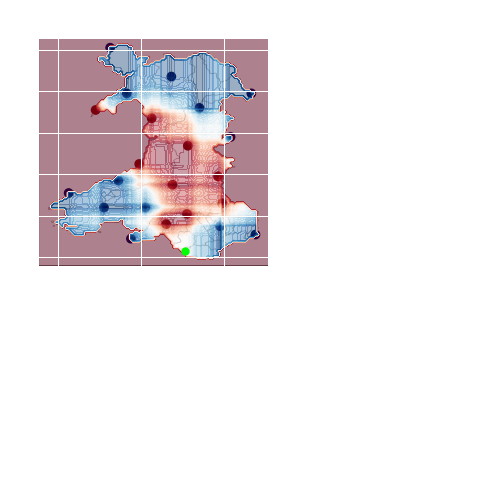

iteration  1
Accuracy is 0.5291290136512209
iteration  2
Accuracy is 0.5864256873678139
iteration  3
Accuracy is 0.71793885791194
iteration  4
Accuracy is 0.6798692559123245
iteration  5
Accuracy is 0.742741780426841
iteration  6
Accuracy is 0.7167852336089213
iteration  7
Accuracy is 0.7767736973658912
iteration  8
Accuracy is 0.7975389348202269
iteration  9
Accuracy is 0.8198423380119207
iteration  10
Accuracy is 0.8046529513555085
iteration  11
Accuracy is 0.7936935204768314
iteration  12
Accuracy is 0.8021534320323015
iteration  13
Accuracy is 0.8200346087290905
iteration  14
Accuracy is 0.8552201499711594
iteration  15
Accuracy is 0.8517592770621034
iteration  16
Accuracy is 0.8454143433955008
iteration  17
Accuracy is 0.8065756585272063
iteration  18
Accuracy is 0.8359930782541819
iteration  19
Accuracy is 0.8442607190924822
iteration  20
Accuracy is 0.8552201499711594
iteration  21
Accuracy is 0.847913862718708
experiment:  1


<IPython.core.display.Javascript object>


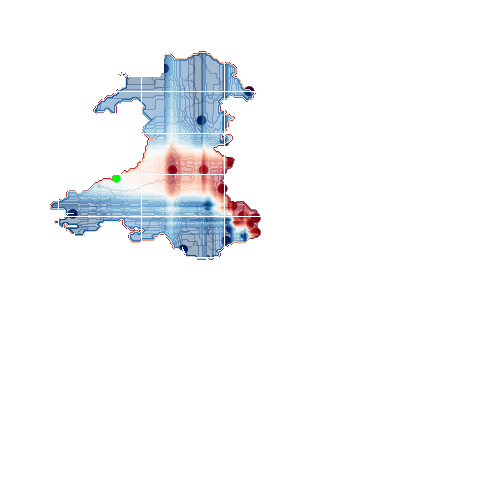

iteration  1
Accuracy is 0.4708709863487791
iteration  2
Accuracy is 0.5575850797923476
iteration  3
Accuracy is 0.6002691790040376
iteration  4
Accuracy is 0.6419919246298789
iteration  5
Accuracy is 0.6254566429532782
iteration  6
Accuracy is 0.6352624495289367
iteration  7
Accuracy is 0.6352624495289367
iteration  8
Accuracy is 0.6410305710440299
iteration  9
Accuracy is 0.6354547202461065
iteration  10
Accuracy is 0.6337242837915785
iteration  11
Accuracy is 0.6377619688521439
iteration  12
Accuracy is 0.6385310517208229
iteration  13
Accuracy is 0.6416073831955393
iteration  14
Accuracy is 0.6414151124783696
iteration  15
Accuracy is 0.6412228417611998
iteration  16
Accuracy is 0.6435300903672371
iteration  17
Accuracy is 0.6523745433570467
iteration  18
Accuracy is 0.6575658527206306
iteration  19
Accuracy is 0.6815996923668526
iteration  20
Accuracy is 0.6819842338011921
iteration  21
Accuracy is 0.7775427802345702
experiment:  2


<IPython.core.display.Javascript object>


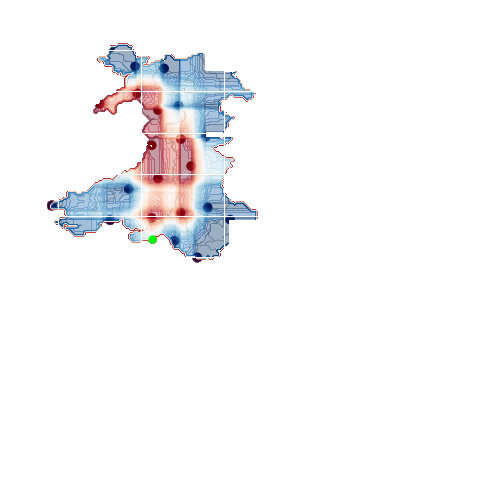

iteration  1
Accuracy is 0.48048452220726784
iteration  2
Accuracy is 0.5500865218227264
iteration  3
Accuracy is 0.6133435877715824
iteration  4
Accuracy is 0.5943087867717747
iteration  5
Accuracy is 0.6692943664679869
iteration  6
Accuracy is 0.6983272447606229
iteration  7
Accuracy is 0.6729475100942126
iteration  8
Accuracy is 0.6837146702557201
iteration  9
Accuracy is 0.6646798692559123
iteration  10
Accuracy is 0.6460296096904441
iteration  11
Accuracy is 0.6671793885791194
iteration  12
Accuracy is 0.6750624879830802
iteration  13
Accuracy is 0.7771582388002307
iteration  14
Accuracy is 0.8146510286483368
iteration  15
Accuracy is 0.78638723322438
iteration  16
Accuracy is 0.842722553355124
iteration  17
Accuracy is 0.8192655258604115
iteration  18
Accuracy is 0.8334935589309748
iteration  19
Accuracy is 0.8142664872139973
iteration  20
Accuracy is 0.8415689290521053
iteration  21
Accuracy is 0.8406075754662565
experiment:  3


<IPython.core.display.Javascript object>


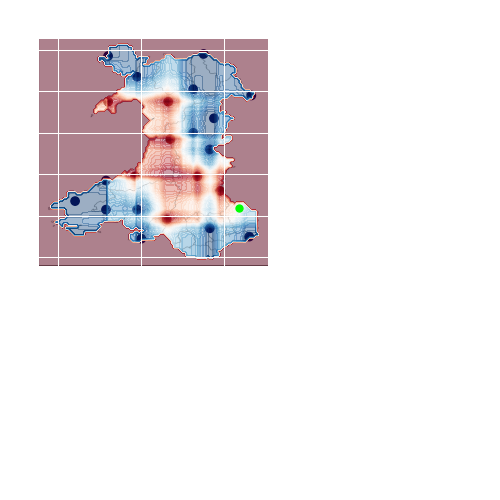

iteration  1
Accuracy is 0.44626033455104785
iteration  2
Accuracy is 0.6585272063064795
iteration  3
Accuracy is 0.7069794270332629
iteration  4
Accuracy is 0.7185156700634493
iteration  5
Accuracy is 0.7106325706594886
iteration  6
Accuracy is 0.7235147087098635
iteration  7
Accuracy is 0.6975581618919439
iteration  8
Accuracy is 0.7069794270332629
iteration  9
Accuracy is 0.7383195539319362
iteration  10
Accuracy is 0.7627379350124976
iteration  11
Accuracy is 0.7744664487598538
iteration  12
Accuracy is 0.7531243991540089
iteration  13
Accuracy is 0.7827340895981542
iteration  14
Accuracy is 0.816189194385695
iteration  15
Accuracy is 0.8206114208805999
iteration  16
Accuracy is 0.8186887137089022
iteration  17
Accuracy is 0.8425302826379543
iteration  18
Accuracy is 0.8554124206883291
iteration  19
Accuracy is 0.855604691405499
iteration  20
Accuracy is 0.8790617189002115
iteration  21
Accuracy is 0.8756008459911555
experiment:  4


<IPython.core.display.Javascript object>


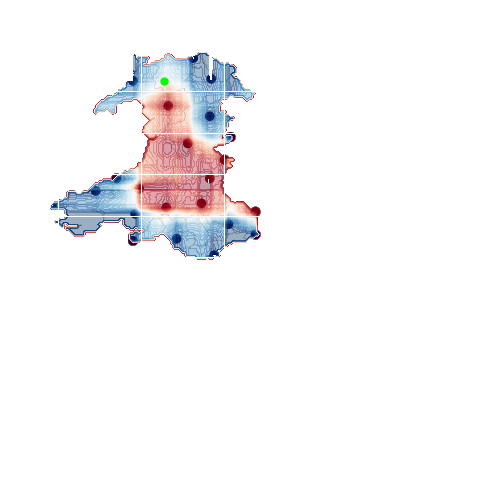

iteration  1
Accuracy is 0.6104595270140357
iteration  2
Accuracy is 0.5387425495097097
iteration  3
Accuracy is 0.5118246491059412
iteration  4
Accuracy is 0.48894443376273794
iteration  5
Accuracy is 0.5110555662372621
iteration  6
Accuracy is 0.6194962507210152
iteration  7
Accuracy is 0.7940780619111709
iteration  8
Accuracy is 0.8123437800422996
iteration  9
Accuracy is 0.7460103826187272
iteration  10
Accuracy is 0.8102288021534321
iteration  11
Accuracy is 0.7919630840223034
iteration  12
Accuracy is 0.8075370121130552
iteration  13
Accuracy is 0.773505095174005
iteration  14
Accuracy is 0.8231109402038069
iteration  15
Accuracy is 0.8194577965775812
iteration  16
Accuracy is 0.8265718131128629
iteration  17
Accuracy is 0.82907133243607
iteration  18
Accuracy is 0.836762161122861
iteration  19
Accuracy is 0.8502211113247452
iteration  20
Accuracy is 0.8481061334358777
iteration  21
Accuracy is 0.8359930782541819
experiment:  5


<IPython.core.display.Javascript object>


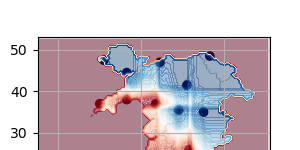

iteration  1
Accuracy is 0.45414343395500867
iteration  2
Accuracy is 0.6283407037108248
iteration  3
Accuracy is 0.7035185541242068
iteration  4
Accuracy is 0.6962122668717554
iteration  5
Accuracy is 0.7711978465679677
iteration  6
Accuracy is 0.710248029225149
iteration  7
Accuracy is 0.7323591616996732
iteration  8
Accuracy is 0.7531243991540089
iteration  9
Accuracy is 0.76062295712363
iteration  10
Accuracy is 0.7815804652951356
iteration  11
Accuracy is 0.847913862718708
iteration  12
Accuracy is 0.8086906364160739
iteration  13
Accuracy is 0.8184964429917324
iteration  14
Accuracy is 0.8419534704864449
iteration  15
Accuracy is 0.8509901941934244
iteration  16
Accuracy is 0.8592578350317247
iteration  17
Accuracy is 0.8534897135166314
iteration  18
Accuracy is 0.8284945202845606
iteration  19
Accuracy is 0.8525283599307826
iteration  20
Accuracy is 0.8459911555470102
iteration  21
Accuracy is 0.8527206306479523
experiment:  6


<IPython.core.display.Javascript object>


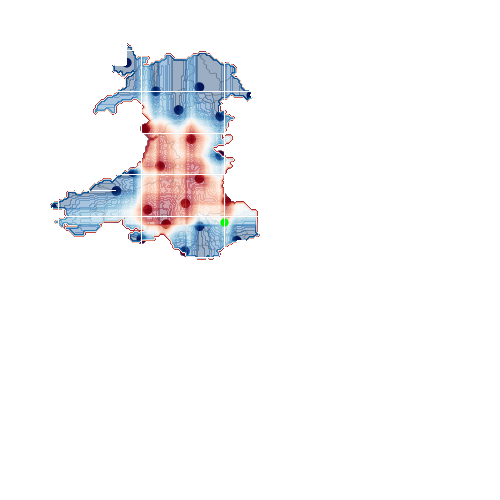

iteration  1
Accuracy is 0.4814458757931167
iteration  2
Accuracy is 0.6965968083060949
iteration  3
Accuracy is 0.7156316093059027
iteration  4
Accuracy is 0.635839261680446
iteration  5
Accuracy is 0.6644875985387425
iteration  6
Accuracy is 0.7156316093059027
iteration  7
Accuracy is 0.7342818688713709
iteration  8
Accuracy is 0.6831378581042107
iteration  9
Accuracy is 0.7527398577196693
iteration  10
Accuracy is 0.8021534320323015
iteration  11
Accuracy is 0.7865795039415497
iteration  12
Accuracy is 0.7708133051336281
iteration  13
Accuracy is 0.7946548740626802
iteration  14
Accuracy is 0.7729282830224957
iteration  15
Accuracy is 0.8227263987694674
iteration  16
Accuracy is 0.8238800230724861
iteration  17
Accuracy is 0.830801768890598
iteration  18
Accuracy is 0.8294558738704095
iteration  19
Accuracy is 0.8388771390117286
iteration  20
Accuracy is 0.84618342626418
iteration  21
Accuracy is 0.8327244760622957
experiment:  7


<IPython.core.display.Javascript object>


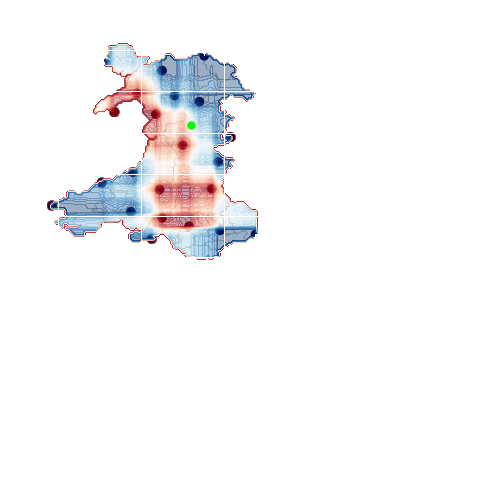

iteration  1
Accuracy is 0.6135358584887521
iteration  2
Accuracy is 0.6460296096904441
iteration  3
Accuracy is 0.7719669294366468
iteration  4
Accuracy is 0.8192655258604115
iteration  5
Accuracy is 0.733320515285522
iteration  6
Accuracy is 0.7652374543357047
iteration  7
Accuracy is 0.7554316477600461
iteration  8
Accuracy is 0.7562007306287253
iteration  9
Accuracy is 0.8044606806383388
iteration  10
Accuracy is 0.8336858296481446
iteration  11
Accuracy is 0.8031147856181503
iteration  12
Accuracy is 0.8579119400115363
iteration  13
Accuracy is 0.8434916362238031
iteration  14
Accuracy is 0.8159969236685253
iteration  15
Accuracy is 0.8411843876177658
iteration  16
Accuracy is 0.8342626417996539
iteration  17
Accuracy is 0.8361853489713517
iteration  18
Accuracy is 0.8434916362238031
iteration  19
Accuracy is 0.8211882330321092
iteration  20
Accuracy is 0.8248413766583349
iteration  21
Accuracy is 0.8329167467794655
experiment:  8


<IPython.core.display.Javascript object>


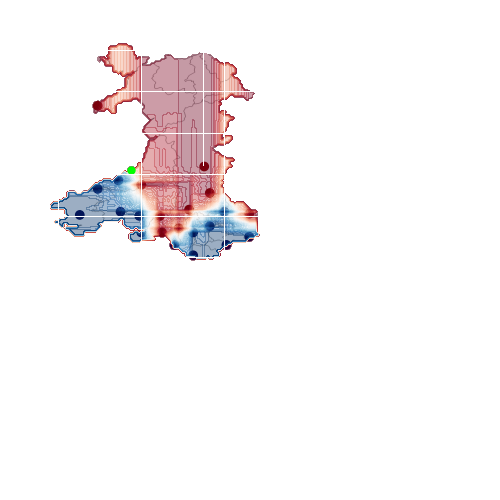

iteration  1
Accuracy is 0.549509709671217
iteration  2
Accuracy is 0.4927898481061334
iteration  3
Accuracy is 0.5408575273985772
iteration  4
Accuracy is 0.5170159584695251
iteration  5
Accuracy is 0.5500865218227264
iteration  6
Accuracy is 0.5395116323783887
iteration  7
Accuracy is 0.576043068640646
iteration  8
Accuracy is 0.5739280907517785
iteration  9
Accuracy is 0.5879638531051721
iteration  10
Accuracy is 0.5829648144587579
iteration  11
Accuracy is 0.6056527590847914
iteration  12
Accuracy is 0.6131513170544126
iteration  13
Accuracy is 0.619688521438185
iteration  14
Accuracy is 0.6252643722361084
iteration  15
Accuracy is 0.6189194385695058
iteration  16
Accuracy is 0.6075754662564892
iteration  17
Accuracy is 0.6181503557008268
iteration  18
Accuracy is 0.6227648529129014
iteration  19
Accuracy is 0.6296865987310133
iteration  20
Accuracy is 0.6269948086906364
iteration  21
Accuracy is 0.6308402230340319
experiment:  9


<IPython.core.display.Javascript object>


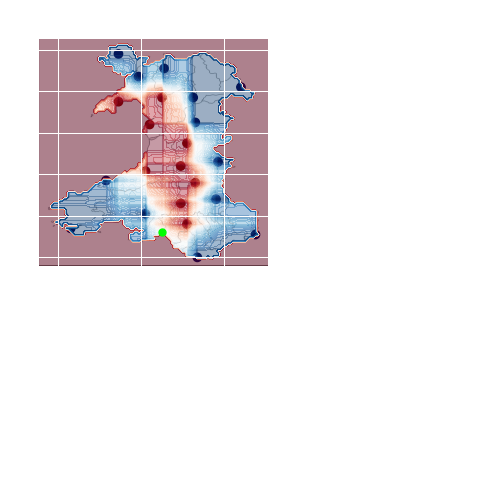

iteration  1
Accuracy is 0.5466256489136705
iteration  2
Accuracy is 0.6344933666602577
iteration  3
Accuracy is 0.7019803883868487
iteration  4
Accuracy is 0.7804268409921169
iteration  5
Accuracy is 0.6835223995385503
iteration  6
Accuracy is 0.6850605652759085
iteration  7
Accuracy is 0.7494712555277832
iteration  8
Accuracy is 0.7533166698711786
iteration  9
Accuracy is 0.7873485868102288
iteration  10
Accuracy is 0.8336858296481446
iteration  11
Accuracy is 0.8198423380119207
iteration  12
Accuracy is 0.8381080561430494
iteration  13
Accuracy is 0.8365698904056912
iteration  14
Accuracy is 0.8215727744664487
iteration  15
Accuracy is 0.8288790617189002
iteration  16
Accuracy is 0.8438761776581427
iteration  17
Accuracy is 0.8559892328398385
iteration  18
Accuracy is 0.8532974427994616
iteration  19
Accuracy is 0.8482984041530475
iteration  20
Accuracy is 0.8673332051528552
iteration  21
Accuracy is 0.8694481830417228
experiment:  10


<IPython.core.display.Javascript object>


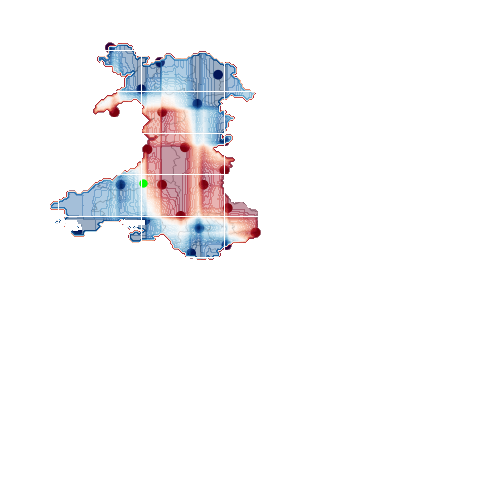

iteration  1
Accuracy is 0.5029801961161315
iteration  2
Accuracy is 0.5398961738127284
iteration  3
Accuracy is 0.5887329359738512
iteration  4
Accuracy is 0.642761007498558
iteration  5
Accuracy is 0.6335320130744088
iteration  6
Accuracy is 0.6706402614881753
iteration  7
Accuracy is 0.6596808306094982
iteration  8
Accuracy is 0.8134974043453183
iteration  9
Accuracy is 0.7844645260526821
iteration  10
Accuracy is 0.7944626033455104
iteration  11
Accuracy is 0.7740819073255143
iteration  12
Accuracy is 0.8127283214766391
iteration  13
Accuracy is 0.8246491059411651
iteration  14
Accuracy is 0.8279177081330513
iteration  15
Accuracy is 0.8582964814458758
iteration  16
Accuracy is 0.8813689675062488
iteration  17
Accuracy is 0.8707940780619112
iteration  18
Accuracy is 0.8782926360315324
iteration  19
Accuracy is 0.8811766967890791
iteration  20
Accuracy is 0.8686791001730436
iteration  21
Accuracy is 0.8842530282637954
experiment:  11


<IPython.core.display.Javascript object>


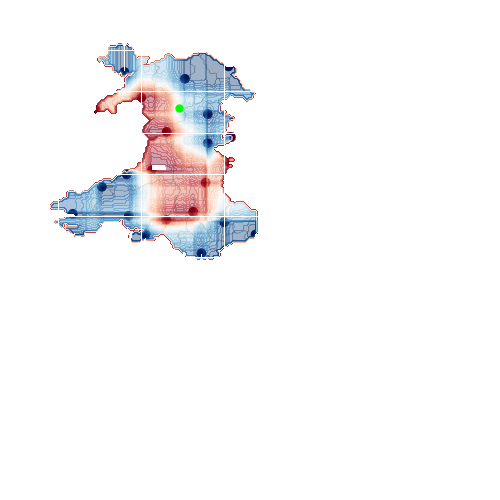

iteration  1
Accuracy is 0.5668140742164969
iteration  2
Accuracy is 0.5775812343780042
iteration  3
Accuracy is 0.606037300519131
iteration  4
Accuracy is 0.5739280907517785
iteration  5
Accuracy is 0.594885598923284
iteration  6
Accuracy is 0.6244952893674294
iteration  7
Accuracy is 0.7189002114977889
iteration  8
Accuracy is 0.7148625264372236
iteration  9
Accuracy is 0.7246683330128821
iteration  10
Accuracy is 0.6679484714477985
iteration  11
Accuracy is 0.6996731397808114
iteration  12
Accuracy is 0.7231301672755239
iteration  13
Accuracy is 0.7842722553355124
iteration  14
Accuracy is 0.8517592770621034
iteration  15
Accuracy is 0.8561815035570083
iteration  16
Accuracy is 0.8523360892136128
iteration  17
Accuracy is 0.8596423764660642
iteration  18
Accuracy is 0.8859834647183235
iteration  19
Accuracy is 0.8921361276677562
iteration  20
Accuracy is 0.8807921553547394
iteration  21
Accuracy is 0.8746394924053067
experiment:  12


<IPython.core.display.Javascript object>


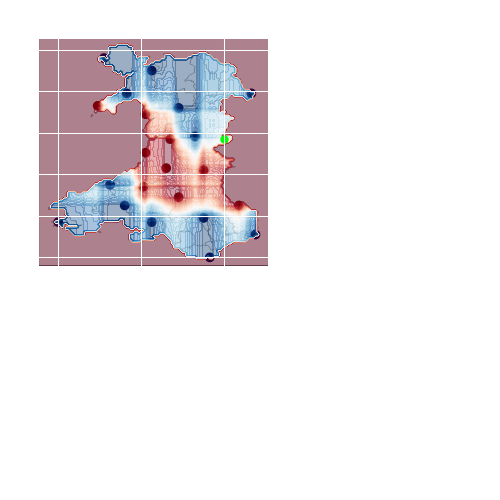

iteration  1
Accuracy is 0.5987310132666794
iteration  2
Accuracy is 0.5118246491059412
iteration  3
Accuracy is 0.5112478369544319
iteration  4
Accuracy is 0.4335704672178427
iteration  5
Accuracy is 0.616227648529129
iteration  6
Accuracy is 0.6433378196500673
iteration  7
Accuracy is 0.6502595654681792
iteration  8
Accuracy is 0.6646798692559123
iteration  9
Accuracy is 0.6533358969428956
iteration  10
Accuracy is 0.6558354162661026
iteration  11
Accuracy is 0.7783118631032494
iteration  12
Accuracy is 0.7567775427802346
iteration  13
Accuracy is 0.7935012497596616
iteration  14
Accuracy is 0.8250336473755047
iteration  15
Accuracy is 0.833301288213805
iteration  16
Accuracy is 0.8283022495673908
iteration  17
Accuracy is 0.8411843876177658
iteration  18
Accuracy is 0.8202268794462604
iteration  19
Accuracy is 0.8263795423956931
iteration  20
Accuracy is 0.8507979234762546
iteration  21
Accuracy is 0.847913862718708
experiment:  13


<IPython.core.display.Javascript object>


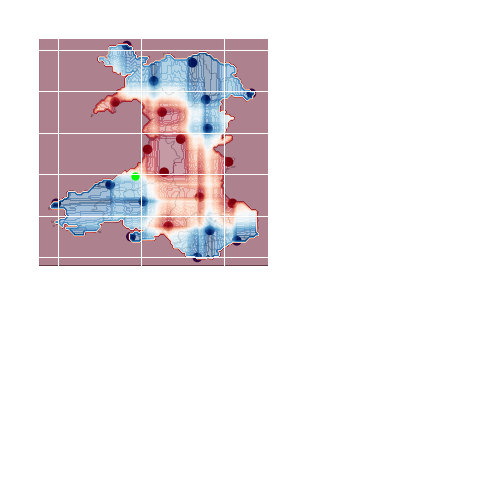

iteration  1
Accuracy is 0.5577773505095174
iteration  2
Accuracy is 0.5297058258027303
iteration  3
Accuracy is 0.6202653335896943
iteration  4
Accuracy is 0.6396846760238416
iteration  5
Accuracy is 0.6121899634685637
iteration  6
Accuracy is 0.7006344933666603
iteration  7
Accuracy is 0.6471832339934628
iteration  8
Accuracy is 0.691405498942511
iteration  9
Accuracy is 0.7731205537396655
iteration  10
Accuracy is 0.7406268025379734
iteration  11
Accuracy is 0.7860026917900403
iteration  12
Accuracy is 0.758123437800423
iteration  13
Accuracy is 0.7900403768506057
iteration  14
Accuracy is 0.8100365314362623
iteration  15
Accuracy is 0.7925398961738127
iteration  16
Accuracy is 0.7969621226687176
iteration  17
Accuracy is 0.836762161122861
iteration  18
Accuracy is 0.8648336858296481
iteration  19
Accuracy is 0.8661795808498366
iteration  20
Accuracy is 0.8756008459911555
iteration  21
Accuracy is 0.8686791001730436
experiment:  14


<IPython.core.display.Javascript object>


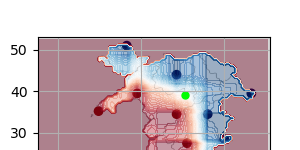

iteration  1
Accuracy is 0.5154777927321669
iteration  2
Accuracy is 0.6056527590847914
iteration  3
Accuracy is 0.6225725821957316
iteration  4
Accuracy is 0.6602576427610075
iteration  5
Accuracy is 0.619688521438185
iteration  6
Accuracy is 0.7335127860026918
iteration  7
Accuracy is 0.7004422226494905
iteration  8
Accuracy is 0.7833109017496636
iteration  9
Accuracy is 0.788117669678908
iteration  10
Accuracy is 0.8265718131128629
iteration  11
Accuracy is 0.8473370505671987
iteration  12
Accuracy is 0.7973466641030571
iteration  13
Accuracy is 0.8040761392039992
iteration  14
Accuracy is 0.8058065756585272
iteration  15
Accuracy is 0.8004229955777735
iteration  16
Accuracy is 0.7917708133051337
iteration  17
Accuracy is 0.8167660065372044
iteration  18
Accuracy is 0.831570851759277
iteration  19
Accuracy is 0.8263795423956931
iteration  20
Accuracy is 0.8338781003653144
iteration  21
Accuracy is 0.8250336473755047
experiment:  15


<IPython.core.display.Javascript object>


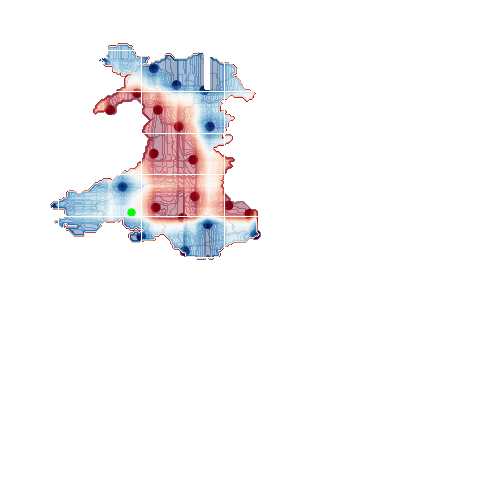

iteration  1
Accuracy is 0.635070178811767
iteration  2
Accuracy is 0.6987117861949625
iteration  3
Accuracy is 0.7804268409921169
iteration  4
Accuracy is 0.6506441069025187
iteration  5
Accuracy is 0.7004422226494905
iteration  6
Accuracy is 0.7786964045375889
iteration  7
Accuracy is 0.7073639684676024
iteration  8
Accuracy is 0.8225341280522976
iteration  9
Accuracy is 0.790617189002115
iteration  10
Accuracy is 0.8140742164968275
iteration  11
Accuracy is 0.8098442607190924
iteration  12
Accuracy is 0.8117669678907903
iteration  13
Accuracy is 0.8454143433955008
iteration  14
Accuracy is 0.858104210728706
iteration  15
Accuracy is 0.850413382041915
iteration  16
Accuracy is 0.875216304556816
iteration  17
Accuracy is 0.857335127860027
iteration  18
Accuracy is 0.8794462603345511
iteration  19
Accuracy is 0.860603730051913
iteration  20
Accuracy is 0.8515670063449337
iteration  21
Accuracy is 0.8669486637185156
experiment:  16


<IPython.core.display.Javascript object>


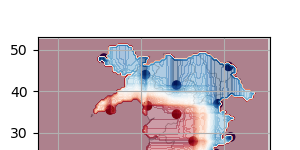

iteration  1
Accuracy is 0.519707748509902
iteration  2
Accuracy is 0.5097096712170737
iteration  3
Accuracy is 0.5537396654489521
iteration  4
Accuracy is 0.5587387040953663
iteration  5
Accuracy is 0.5616227648529128
iteration  6
Accuracy is 0.5566237262064988
iteration  7
Accuracy is 0.6483368582964815
iteration  8
Accuracy is 0.8038838684868295
iteration  9
Accuracy is 0.7181311286291098
iteration  10
Accuracy is 0.715439338588733
iteration  11
Accuracy is 0.7392809075177851
iteration  12
Accuracy is 0.7736973658911748
iteration  13
Accuracy is 0.8173428186887137
iteration  14
Accuracy is 0.7954239569313594
iteration  15
Accuracy is 0.8036915977696597
iteration  16
Accuracy is 0.8159969236685253
iteration  17
Accuracy is 0.821380503749279
iteration  18
Accuracy is 0.848682945587387
iteration  19
Accuracy is 0.8484906748702172
iteration  20
Accuracy is 0.8594501057488945
iteration  21
Accuracy is 0.8696404537588925
experiment:  17


<IPython.core.display.Javascript object>


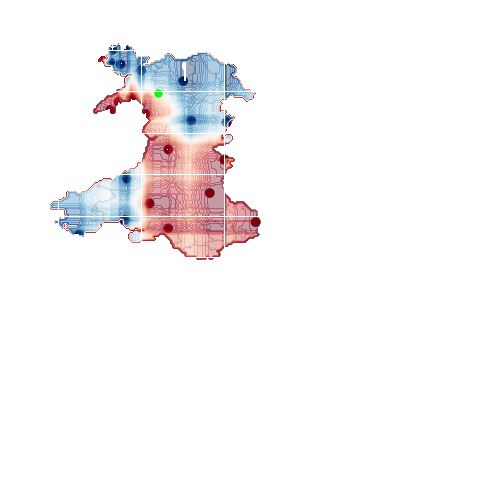

iteration  1
Accuracy is 0.5654681791963084
iteration  2
Accuracy is 0.5833493558930974
iteration  3
Accuracy is 0.5810421072870602
iteration  4
Accuracy is 0.5808498365698904
iteration  5
Accuracy is 0.605075946933282
iteration  6
Accuracy is 0.6108440684483754
iteration  7
Accuracy is 0.620457604306864
iteration  8
Accuracy is 0.6246875600845991
iteration  9
Accuracy is 0.621418957892713
iteration  10
Accuracy is 0.6235339357815805
iteration  11
Accuracy is 0.6231493943472409
iteration  12
Accuracy is 0.6973658911747741
iteration  13
Accuracy is 0.7256296865987311
iteration  14
Accuracy is 0.7590847913862718
iteration  15
Accuracy is 0.7629302057296674
iteration  16
Accuracy is 0.7648529129013651
iteration  17
Accuracy is 0.7765814266487214
iteration  18
Accuracy is 0.8086906364160739
iteration  19
Accuracy is 0.7673524322245722
iteration  20
Accuracy is 0.8052297635070179
iteration  21
Accuracy is 0.7992693712747548
experiment:  18


<IPython.core.display.Javascript object>


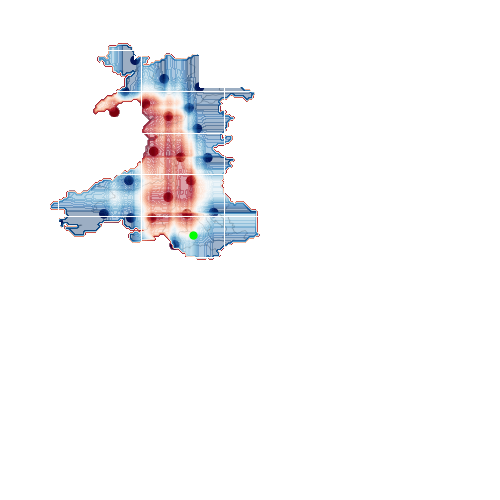

iteration  1
Accuracy is 0.40242261103633914
iteration  2
Accuracy is 0.502595654681792
iteration  3
Accuracy is 0.49490482599500096
iteration  4
Accuracy is 0.6289175158623341
iteration  5
Accuracy is 0.7167852336089213
iteration  6
Accuracy is 0.7460103826187272
iteration  7
Accuracy is 0.800807537012113
iteration  8
Accuracy is 0.8021534320323015
iteration  9
Accuracy is 0.7850413382041915
iteration  10
Accuracy is 0.7646606421841954
iteration  11
Accuracy is 0.8140742164968275
iteration  12
Accuracy is 0.8404153047490868
iteration  13
Accuracy is 0.8327244760622957
iteration  14
Accuracy is 0.8375312439915401
iteration  15
Accuracy is 0.8302249567390886
iteration  16
Accuracy is 0.8369544318400307
iteration  17
Accuracy is 0.855604691405499
iteration  18
Accuracy is 0.8456066141126707
iteration  19
Accuracy is 0.8561815035570083
iteration  20
Accuracy is 0.8548356085368198
iteration  21
Accuracy is 0.8744472216881369
experiment:  19


<IPython.core.display.Javascript object>


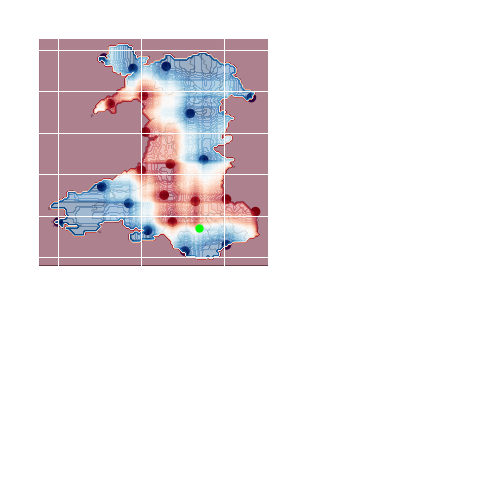

iteration  1
Accuracy is 0.5750817150547971
iteration  2
Accuracy is 0.5035570082676408
iteration  3
Accuracy is 0.5614304941357431
iteration  4
Accuracy is 0.5468179196308403
iteration  5
Accuracy is 0.6250721015189387
iteration  6
Accuracy is 0.7010190348009998
iteration  7
Accuracy is 0.7377427417804269
iteration  8
Accuracy is 0.7556239184772159
iteration  9
Accuracy is 0.7500480676792924
iteration  10
Accuracy is 0.7371659296289175
iteration  11
Accuracy is 0.7587002499519323
iteration  12
Accuracy is 0.7552393770428764
iteration  13
Accuracy is 0.7567775427802346
iteration  14
Accuracy is 0.7617765814266487
iteration  15
Accuracy is 0.7413958854066526
iteration  16
Accuracy is 0.7950394154970198
iteration  17
Accuracy is 0.8181119015573928
iteration  18
Accuracy is 0.827340895981542
iteration  19
Accuracy is 0.8348394539511632
iteration  20
Accuracy is 0.8667563930013459
iteration  21
Accuracy is 0.8757931167083253
experiment:  20


<IPython.core.display.Javascript object>


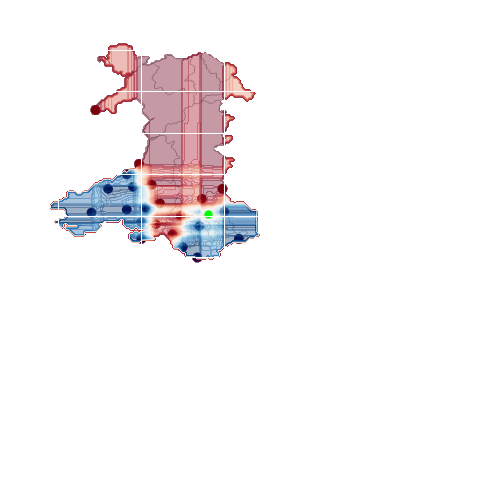

iteration  1
Accuracy is 0.5320130744087676
iteration  2
Accuracy is 0.4939434724091521
iteration  3
Accuracy is 0.5143241684291482
iteration  4
Accuracy is 0.5100942126514132
iteration  5
Accuracy is 0.5174004999038646
iteration  6
Accuracy is 0.5245145164391464
iteration  7
Accuracy is 0.5372043837723515
iteration  8
Accuracy is 0.5541242068832917
iteration  9
Accuracy is 0.560661411267064
iteration  10
Accuracy is 0.5762353393578158
iteration  11
Accuracy is 0.5893097481253605
iteration  12
Accuracy is 0.5996923668525284
iteration  13
Accuracy is 0.600845991155547
iteration  14
Accuracy is 0.6014228033070563
iteration  15
Accuracy is 0.600845991155547
iteration  16
Accuracy is 0.6002691790040376
iteration  17
Accuracy is 0.6062295712363007
iteration  18
Accuracy is 0.5979619303980004
iteration  19
Accuracy is 0.5968083060949817
iteration  20
Accuracy is 0.6056527590847914
iteration  21
Accuracy is 0.6006537204383773


In [7]:
from random import randint
import time

valid_seeds = [4,27,12,15,17,21,23,24,25,28,31,32,35,36,37,41,42,43,45,48,420]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            braninColor(landpoints[value],threshold)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], braninColor(nextpoint,threshold)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [8]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 60.62 %
Improvement is = 7.42 %


In [9]:
Results

[[0.5291290136512209,
  0.5864256873678139,
  0.71793885791194,
  0.6798692559123245,
  0.742741780426841,
  0.7167852336089213,
  0.7767736973658912,
  0.7975389348202269,
  0.8198423380119207,
  0.8046529513555085,
  0.7936935204768314,
  0.8021534320323015,
  0.8200346087290905,
  0.8552201499711594,
  0.8517592770621034,
  0.8454143433955008,
  0.8065756585272063,
  0.8359930782541819,
  0.8442607190924822,
  0.8552201499711594,
  0.847913862718708],
 [0.4708709863487791,
  0.5575850797923476,
  0.6002691790040376,
  0.6419919246298789,
  0.6254566429532782,
  0.6352624495289367,
  0.6352624495289367,
  0.6410305710440299,
  0.6354547202461065,
  0.6337242837915785,
  0.6377619688521439,
  0.6385310517208229,
  0.6416073831955393,
  0.6414151124783696,
  0.6412228417611998,
  0.6435300903672371,
  0.6523745433570467,
  0.6575658527206306,
  0.6815996923668526,
  0.6819842338011921,
  0.7775427802345702],
 [0.48048452220726784,
  0.5500865218227264,
  0.6133435877715824,
  0.5943087

In [10]:
np.savetxt('Branin_bestpls', Results)

In [11]:
tst = np.loadtxt('Branin_best')

OSError: Branin_best not found.

In [ ]:
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns

# define a and b here
a = tst
b = []
for i in range(21):
    b.append(i+1)

# Helps pick a random color for each plot, used for readability
rand = lambda: random.randint(0, 255)
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
ax.set(ylim=(0.4, 1))
for ydata in a:
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    plot, = ax.plot(b, ydata, color=clr, alpha = 0.2)
    sns.boxplot(data=tst)